# <font color = 'blue'> AV2

## <font color = purple> Importanto bibliotecas e dados

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix
from lib.metrics import Metrics


In [14]:
Dados = pd.read_csv('../data/spiral.csv').values
Size = Dados.shape
X = Dados[:, 0:Size[1]-1].reshape(Size[0], Size[1]-1)
y = Dados[:, Size[1]-1].reshape(Size[0], 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 25)

## <font color = purple> Funções de ativação

In [5]:
# funções de ativação 
def sigmoide(x):
    return 1 / (1 + np.exp(-x))

def sigmoide_derivada(x):
    return sigmoide(x) * (1 - sigmoide(x))

def tanh(x):
    return np.tanh(x)

def tanh_derivada(x):
    return 1 - np.tanh(x)**2

## <font color = purple> Classes

### <font color = green> RBF

In [4]:
class RBF:
    def __init__(self, k, funcao_ativacao, limiar, epocas, tolerancia, learning_rate):
        self.k = k
        self.funcao_ativacao = funcao_ativacao
        self.epocas = epocas
        self.tolerancia = tolerancia
        self.limiar = limiar
        self.learning_rate = learning_rate

    def _kmeans(self, X, k, epocas, tolerancia):
        np.random.seed(42)
        centros = X[np.random.choice(X.shape[0], k, replace=False)]
        distances = np.zeros((X.shape[0], k))

        for _ in range(epocas):
            for i, c in enumerate(centros):
                distances[:, i] = np.linalg.norm(X - c, axis=1)
            labels = np.argmin(distances, axis=1)
            novos_centros = np.array([X[labels == i].mean(axis=0) for i in range(k)])

            if np.linalg.norm(novos_centros - centros) < tolerancia:
                break
            centros = novos_centros

        return centros


    def _rbf(self, X, center, sigma):
        return np.exp(-np.sum((X - center) ** 2, axis=1) / (2 * sigma ** 2))


    def _sigma(self, centros):
        distancias = np.zeros((centros.shape[0], centros.shape[0]))
        for i in range(centros.shape[0]):
            for j in range(centros.shape[0]):
                distancias[i, j] = np.linalg.norm(centros[i] - centros[j])

        np.fill_diagonal(distancias, np.inf)
        return np.min(distancias) / np.sqrt(2 * self.k)



    def treinar(self, X, y):
        self.centers = self._kmeans(X, self.k, self.epocas, self.tolerancia)
        self.sigma = self._sigma(self.centers)

        rbf_matrix = np.zeros((X.shape[0], self.k))
        for i in range(self.k):
            rbf_matrix[:, i] = self._rbf(X, self.centers[i], self.sigma)

        self.weights = np.linalg.pinv(rbf_matrix.T @ rbf_matrix) @ rbf_matrix.T @ y.reshape(-1, 1)

    def prever(self, X):
        rbf_matrix = np.zeros((X.shape[0], self.k))
        for i in range(self.k):
            rbf_matrix[:, i] = self._rbf(X, self.centers[i], self.sigma)

        y_pred = self.funcao_ativacao(rbf_matrix @ self.weights)
        return y_pred

    def acuracia(self, y_pred, y_true):
        y_pred = np.where(y_pred >= self.limiar, 1, 0) 
        return np.mean(y_pred == y_true.reshape(-1, 1))

#


### <font color = green> Classe MLP

In [6]:
class MLP:
    def __init__(self, camadas, funcao_ativacao, funcao_ativacao_derivada, erro_minimo, learning_rate=0.05, epocas=10000, limiar=0.50, ):
        self.camadas = camadas
        self.funcao_ativacao = funcao_ativacao
        self.funcao_ativacao_derivada = funcao_ativacao_derivada
        self.learning_rate = learning_rate
        self.epocas = epocas
        self.limiar = limiar
        self.erro_minimo = erro_minimo
        self.pesos, self.biases = self.iniciando_pesos()
        

    def iniciando_pesos(self):
        np.random.seed(42)  
        pesos = []  
        biases = []  

        for i in range(len(self.camadas) - 1):
            
            pesos.append(np.random.randn(self.camadas[i], self.camadas[i + 1]))
            biases.append(np.zeros((1, self.camadas[i + 1])))

        return pesos, biases

    def treinar(self, X_train, y_train):
        m = X_train.shape[0] 
        epoca = 0

        for epoca in range(self.epocas):
            saidas = [X_train] 
            zs = [] 

            for i in range(len(self.camadas) - 1):
                z = saidas[-1] @ self.pesos[i] + self.biases[i]
                zs.append(z) 
                
                a = self.funcao_ativacao(z)
                saidas.append(a) 

            erro = np.sum(np.square(y_train.reshape(-1, 1) - saidas[-1])) / (2 * m)
            if (erro <= self.erro_minimo):
                #print('parou devido ao erro')
                break
            
            delta = (saidas[-1] - y_train.reshape(-1, 1)) * self.funcao_ativacao_derivada(zs[-1])
            dW = (1 / m) * (saidas[-2].T @ delta)  
            db = (1 / m) * np.sum(delta, axis=0, keepdims=True)  
            peso_atualizado = [dW]  
            bias_atualizado = [db]
        

            for i in range(len(self.camadas) - 3, -1, -1):
                delta = (delta @ self.pesos[i + 1].T) * self.funcao_ativacao_derivada(zs[i])
                
                dW = (1 / m) * (saidas[i].T @ delta)
                
                db = (1 / m) * np.sum(delta, axis=0, keepdims=True)
                
                peso_atualizado.insert(0, dW)
                bias_atualizado.insert(0, db)

            for i in range(len(self.pesos)):
                self.pesos[i] -= self.learning_rate * peso_atualizado[i]
                self.biases[i] -= self.learning_rate * bias_atualizado[i]
                
            epoca+=1   
            if(epoca == self.epocas):    
                #print('parou devido ao numero de max de épocas pré definido')
                break  
        

    def prever(self, X):
        saidas = [X]
        for i in range(len(self.camadas) - 1):
            z = saidas[-1] @ self.pesos[i] + self.biases[i]
            a = self.funcao_ativacao(z)
            saidas.append(a)

        # mudar o limite do limiar dependendo da função de ativação
        y_pred = np.where(saidas[-1] >= self.limiar, 1, -1)
        return y_pred

    def acuracia(self, y_pred, y_true):
        return np.mean(y_pred == y_true)



### <font color = green>Classe Perceptron simples

In [7]:
class Perceptron:
    def __init__(self, learning_rate, erro_minimo, epocas):
        self.learning_rate = learning_rate
        self.erro_minimo = erro_minimo
        self.epocas = epocas
        self.W = None

    def treinar(self, X_train, y_train):
        X_train = X_train.T
        X_train = np.concatenate((-np.ones((1, X_train.shape[1])), X_train), axis=0)

        y_train.shape = (len(y_train), 1)

        self.W = np.random.random_sample((X_train.shape[0], 1)) - 0.5

        epoch = 0

        while True:
            epoch += 1
            acertos = 0
            total_error = 0
            for t in range(X_train.shape[1]):
                x_t = X_train[:, t].reshape(X_train.shape[0], 1)
                u_t = self.W.T @ x_t
                y_t = sigmoide(u_t[0, 0])

                # Define o limiar de classificação
                y_t = 1 if y_t > 0.6 else -1

                d_t = y_train[t, 0]
                if y_t == d_t:
                    acertos += 1
                error = d_t - y_t
                self.W = self.W + self.learning_rate * error * x_t
                total_error += abs(error)


            mean_error = total_error / X_train.shape[1]

            if mean_error < self.erro_minimo or epoch >= self.epocas:
                break
        acuracia = acertos / X_train.shape[1]
        return acuracia

    def prever(self, X_test):
        X_test = X_test.T
        X_test = np.concatenate((-np.ones((1, X_test.shape[1])), X_test), axis=0)

        y_pred = []
        for t in range(X_test.shape[1]):
            x_t = X_test[:, t].reshape(X_test.shape[0], 1)
            u_t = self.W.T @ x_t
            y_t = sigmoide(u_t[0, 0])
            y_t = 1 if y_t > 0.6 else -1
            y_pred.append(y_t)
        return np.array(y_pred)

    def acuracia(self, X, y):
        X = X.T
        X = np.concatenate((-np.ones((1, X.shape[1])), X), axis=0)

        y.shape = (len(y), 1)

        acertos = 0
        for t in range(X.shape[1]):
            x_t = X[:, t].reshape(X.shape[0], 1)
            u_t = self.W.T @ x_t
            y_t = sigmoide(u_t[0, 0])
            y_t = 1 if y_t >= 0.6 else -1
            d_t = y[t, 0]
            if y_t == d_t:
                acertos += 1
        acuracia = acertos / X.shape[1]
        return acuracia


### <font color = green>Classe Adaline

In [8]:
class Adaline:
    def __init__(self, learning_rate, erro_minimo, epocas):
        self.learning_rate = learning_rate
        self.erro_minimo = erro_minimo
        self.epocas = epocas
        self.W = None

    def treinar(self, X_train, y_train):
        X_train = X_train.T
        X_train = np.concatenate((-np.ones((1, X_train.shape[1])), X_train), axis=0)

        y_train.shape = (len(y_train), 1)

        self.W = np.random.random_sample((X_train.shape[0], 1)) - 0.5

        epoch = 0

        while True:
            epoch += 1
            total_error = 0
            for t in range(X_train.shape[1]):
                x_t = X_train[:, t].reshape(X_train.shape[0], 1)
                u_t = self.W.T @ x_t
                y_t = u_t[0, 0]

                d_t = y_train[t, 0]
                error = d_t - y_t
                self.W = self.W + self.learning_rate * error * x_t
                total_error += abs(error)

            mean_error = total_error / X_train.shape[1]

            if mean_error < self.erro_minimo or epoch >= self.epocas:
                break

    def prever(self, X_test):
        X_test = X_test.T
        X_test = np.concatenate((-np.ones((1, X_test.shape[1])), X_test), axis=0)

        y_pred = []
        for t in range(X_test.shape[1]):
            x_t = X_test[:, t].reshape(X_test.shape[0], 1)
            u_t = self.W.T @ x_t
            y_t = u_t[0, 0]
            y_t = 1 if y_t > 0.7 else -1
            y_pred.append(y_t)
        return np.array(y_pred)

    def acuracia(self, X, y):
        X = X.T
        X = np.concatenate((-np.ones((1, X.shape[1])), X), axis=0)

        y.shape = (len(y), 1)

        acertos = 0
        for t in range(X.shape[1]):
            x_t = X[:, t].reshape(X.shape[0], 1)
            u_t = self.W.T @ x_t
            y_t = u_t[0, 0]
            y_t = 1 if y_t > 0.6 else -1
            d_t = y[t, 0]
            if y_t == d_t:
                acertos += 1
        acuracia = acertos / X.shape[1]
        return acuracia


## <font color = purple> Perceptron simples

In [9]:
learning_rate = 0.005
erro_minimo = 0.005
epocas = 100

In [20]:
perceptron_df = []

for i in range(10):
    perceptron = Perceptron(learning_rate=learning_rate, erro_minimo=erro_minimo,epocas=epocas)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = i)

    perceptron.treinar(X_train, y_train)
    y_pred = perceptron.prever(X_train)

    metrics_train = Metrics(y_train, y_pred)
    accuracy_train = metrics_train.accuracy()
    sensitivity_train = metrics_train.sensitivity()
    specificity_train = metrics_train.specificity()

    y_pred = perceptron.prever(X_test)
    metrics_test = Metrics(y_test, y_pred)
    accuracy_test = metrics_test.accuracy()
    sensitivity_test = metrics_test.sensitivity()
    specificity_test = metrics_test.specificity()


    perceptron_data = {'accuracy_train': accuracy_train, 'accuracy_test': accuracy_test, 'sensitivity_train': sensitivity_train, 'sensitivity_test': sensitivity_test, 'specificity_train': specificity_train, 'specificity_test': specificity_test}
    perceptron_df.append(perceptron_data)

perceptron_df = pd.DataFrame(perceptron_df)
perceptron_df.describe()


,accuracy_train,accuracy_test,sensitivity_train,sensitivity_test,specificity_train,specificity_test
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.634522,0.640250,0.623721,0.629310,0.645405,0.651616
std,0.055343,0.061739,0.060224,0.067084,0.054017,0.065119
min,0.550344,0.525000,0.534739,0.528497,0.566204,0.521739
25%,0.590056,0.611250,0.572511,0.576054,0.616612,0.645606
50%,0.644778,0.666250,0.629447,0.633587,0.645026,0.663384
75%,0.678862,0.687500,0.677754,0.687651,0.680883,0.692737
max,0.711069,0.700000,0.696970,0.714286,0.724907,0.730570


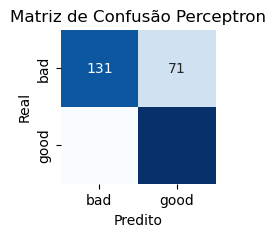

In [28]:
perceptron = Perceptron(learning_rate=learning_rate, erro_minimo=erro_minimo,epocas=epocas)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 11)
perceptron.treinar(X_train, y_train)
y_pred = perceptron.prever(X_test)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(2, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['bad', 'good'], yticklabels=['bad', 'good'])
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão Perceptron')
plt.show()

## <font color = purple> Adaline

In [32]:
learning_rate = 0.05
erro_minimo = 0.001
epocas = 100

In [18]:
adaline_df = []

for i in range(10):
    perceptron = Adaline(learning_rate, erro_minimo, epocas)  
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)

    perceptron.treinar(X_train, y_train)
    y_pred = perceptron.prever(X_train)

    metrics_train = Metrics(y_train, y_pred)
    accuracy_train = metrics_train.accuracy()
    sensitivity_train = metrics_train.sensitivity()
    specificity_train = metrics_train.specificity()

    y_pred = perceptron.prever(X_test)
    metrics_test = Metrics(y_test, y_pred)
    accuracy_test = metrics_test.accuracy()
    sensitivity_test = metrics_test.sensitivity()
    specificity_test = metrics_test.specificity()


    adaline_data = {'accuracy_train': accuracy_train, 'accuracy_test': accuracy_test, 'sensitivity_train': sensitivity_train, 'sensitivity_test': sensitivity_test, 'specificity_train': specificity_train, 'specificity_test': specificity_test}
    adaline_df.append(adaline_data)
    

adaline_df = pd.DataFrame(adaline_df)
print(adaline_df)



   accuracy_train  accuracy_test  sensitivity_train  sensitivity_test  \
0        0.692308         0.6575           0.423126          0.415094   
1        0.582864         0.5675           0.331671          0.299492   
2        0.668543         0.6525           0.383750          0.381910   
3        0.500938         0.5300           0.235885          0.272277   
4        0.560350         0.5425           0.388337          0.409326   
5        0.712946         0.7325           0.458073          0.490000   
6        0.616635         0.6775           0.337037          0.375661   
7        0.707942         0.7250           0.453865          0.461929   
8        0.628518         0.6225           0.293970          0.295567   
9        0.674171         0.6425           0.342172          0.309179   

   specificity_train  specificity_test  
0           0.953202          0.930851  
1           0.835634          0.827586  
2           0.953692          0.920398  
3           0.764339          0.

/tmp/ipykernel_3515/196979337.py:29: RuntimeWarning: overflow encountered in scalar add
  total_error += abs(error)
/tmp/ipykernel_3515/196979337.py:23: RuntimeWarning: overflow encountered in matmul
  u_t = self.W.T @ x_t
/tmp/ipykernel_3515/196979337.py:23: RuntimeWarning: invalid value encountered in matmul
  u_t = self.W.T @ x_t


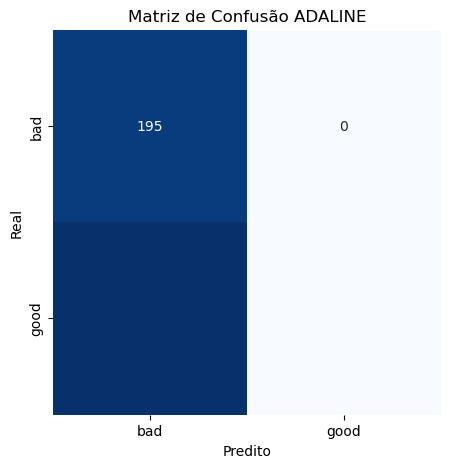

In [35]:
perceptron = Adaline(learning_rate, erro_minimo, epocas)  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 22)

perceptron.treinar(X_train, y_train)
y_pred = perceptron.prever(X_test)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['bad', 'good'], yticklabels=['bad', 'good'])
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão ADALINE')
plt.show()

## <font color = purple> Treinamento e teste MLP

### <font color = green> Sigmoide

In [33]:
learning_rate = 0.001
epocas = 1000
limiar = 0.6
camada_de_entrada = X_train.shape[1] # como dito em sala, isso é fixo.... mas poderia não ser.
camada_de_saida = 1 # no meu caso é uma classificação binária de atmosfera 'good' ou 'bad'
camadas_escondidas = [20]
camadas=[camada_de_entrada] + camadas_escondidas + [camada_de_saida]
erro = 0.005

In [34]:
mlp_df = []

for i in range(10):
    mlp = MLP(camadas=camadas, funcao_ativacao=sigmoide, funcao_ativacao_derivada=sigmoide_derivada, erro_minimo=erro, learning_rate=learning_rate, epocas=epocas, limiar = limiar)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = i)

    mlp.treinar(X_train, y_train)
    y_pred = mlp.prever(X_train)

    metrics_train = Metrics(y_train, y_pred)
    accuracy_train = metrics_train.accuracy()
    sensitivity_train = metrics_train.sensitivity()
    specificity_train = metrics_train.specificity()

    y_pred = mlp.prever(X_test)
    metrics_test = Metrics(y_test, y_pred)
    accuracy_test = metrics_test.accuracy()
    sensitivity_test = metrics_test.sensitivity()
    specificity_test = metrics_test.specificity()


    mlp_data = {'accuracy_train': accuracy_train, 'accuracy_test': accuracy_test, 'sensitivity_train': sensitivity_train, 'sensitivity_test': sensitivity_test, 'specificity_train': specificity_train, 'specificity_test': specificity_test}
    mlp_df.append(mlp_data)

mlp_df = pd.DataFrame(perceptron_df)
mlp_df.describe()

,accuracy_train,accuracy_test,sensitivity_train,sensitivity_test,specificity_train,specificity_test
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.634522,0.640250,0.623721,0.629310,0.645405,0.651616
std,0.055343,0.061739,0.060224,0.067084,0.054017,0.065119
min,0.550344,0.525000,0.534739,0.528497,0.566204,0.521739
25%,0.590056,0.611250,0.572511,0.576054,0.616612,0.645606
50%,0.644778,0.666250,0.629447,0.633587,0.645026,0.663384
75%,0.678862,0.687500,0.677754,0.687651,0.680883,0.692737
max,0.711069,0.700000,0.696970,0.714286,0.724907,0.730570


0.915


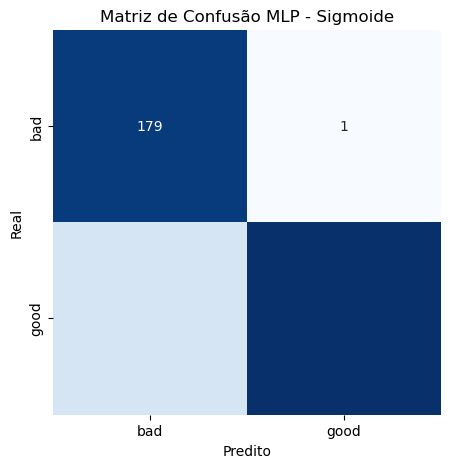

In [25]:
mlp = MLP(camadas=camadas, funcao_ativacao=sigmoide, funcao_ativacao_derivada=sigmoide_derivada, erro_minimo=erro, learning_rate=learning_rate, epocas=epocas, limiar = limiar)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 25)

mlp.treinar(X_train, y_train)
y_pred = mlp.prever(X_test)

print(mlp.acuracia(y_pred, y_test))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['bad', 'good'], yticklabels=['bad', 'good'])
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão MLP - Sigmoide')
plt.show()

### <font color = green> Tangente hiperbolica

In [38]:
learning_rate = 0.01
epocas = 1000
limiar = 0.5
camada_de_entrada = X_train.shape[1] # como dito em sala, isso é fixo.... mas poderia não ser.
camada_de_saida = 1 # no meu caso é uma classificação binária de atmosfera 'good' ou 'bad'
camadas_escondidas = [50, 20, 10]
camadas=[camada_de_entrada] + camadas_escondidas + [camada_de_saida]
erro = 0.01

In [40]:
mlp_df_tanh = []

for i in range(1):
    mlp = MLP(camadas=camadas, funcao_ativacao=tanh, funcao_ativacao_derivada=tanh_derivada, erro_minimo=erro, learning_rate=learning_rate, epocas=epocas, limiar = limiar)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = i)

    mlp.treinar(X_train, y_train)

    y_pred_treino_mlp_tanh = mlp.prever(X_train)
    acuracia_treino_mlp_tanh = mlp.acuracia(y_pred_treino_mlp_tanh, y_train)

    y_pred_teste_mlp_tanh = mlp.prever(X_test)
    acuracia_teste_mlp_tanh = mlp.acuracia(y_pred_teste_mlp_tanh, y_test)

    acuracias_mlp_tahn = {'acuracia_treino': acuracia_treino_mlp_tanh, 'acuracia_teste': acuracia_teste_mlp_tanh}
    
    mlp_df_tanh.append(pd.DataFrame(acuracias_mlp_tahn, index=[i]))

mlp = pd.concat(mlp_df_tanh)

mlp.style.highlight_max(subset=['acuracia_treino', 'acuracia_teste'], color='blue', axis=0)

,acuracia_treino,acuracia_teste
0,0.929956,0.902500


[[209   0]
 [ 24 167]]


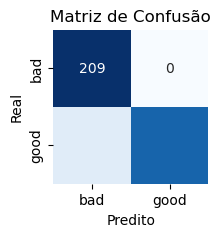

In [42]:
mlp = MLP(camadas=camadas, funcao_ativacao=tanh, funcao_ativacao_derivada=tanh_derivada, erro_minimo=erro, learning_rate=learning_rate, epocas=epocas, limiar = limiar)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 15)

mlp.treinar(X_train, y_train)
y_pred = mlp.prever(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)

plt.figure(figsize=(2, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['bad', 'good'], yticklabels=['bad', 'good'])
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

## <font color = purple> Treinamento e teste RBF

In [23]:
k= 5
epocas=10000
tolerancia=0.001
learning_rate = 0.01
limiar = 0.6

In [31]:
rbf = RBF(k=k, funcao_ativacao = sigmoide, epocas=epocas, tolerancia=tolerancia, limiar = limiar, learning_rate=learning_rate)

rbf_df = []

for i in range(100):
    rbf = RBF(k=k, funcao_ativacao = sigmoide, epocas=epocas, tolerancia=tolerancia, limiar = limiar, learning_rate=learning_rate)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = i)

    rbf.treinar(X_train, y_train)

    y_pred = rbf.prever(X_train)
    acuracia_treino = rbf.acuracia(y_pred, y_train)

    y_pred = rbf.prever(X_test)
    acuracia_teste = rbf.acuracia(y_pred, y_test)


    acuracias_rbf = {'acuracia_treino': acuracia_treino, 'acuracia_teste': acuracia_teste}

    rbf_df.append(pd.DataFrame(acuracias_rbf, index=[i]))

rbf = pd.concat(rbf_df)

rbf.style.highlight_max(subset=['acuracia_treino', 'acuracia_teste'], color='blue', axis=0)



,acuracia_treino,acuracia_teste
0,0.757143,0.788732
1,0.710714,0.718310
2,0.817857,0.845070
3,0.739286,0.718310
4,0.642857,0.450704
5,0.671429,0.591549
6,0.682143,0.718310
7,0.707143,0.732394
8,0.664286,0.605634
9,0.642857,0.549296


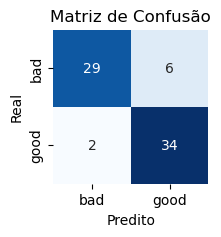

In [32]:
rbf = RBF(k=k, funcao_ativacao = sigmoide, epocas=epocas, tolerancia=tolerancia, limiar = limiar, learning_rate=learning_rate)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 2)

rbf.treinar(X_train, y_train)
y_pred = perceptron.prever(X_test)

cm = confusion_matrix(y_test, (y_pred > 0.5).astype(int))

plt.figure(figsize=(2, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['bad', 'good'], yticklabels=['bad', 'good'])
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()
